# Officially: Statistical analysis for science in Python
# Actually: **BASIC** statistics in climate science

### What this notebook is not
- a math lesson
- advanced stats
- clever ways of doing stats
- properly written
- good looking


### What this notebook is
A toolbox with examples for basic model evaluation, curve fitting, trend computation... all written in very naive ways

## The three mantras for today

><cite>Deep Thought:</cite> “The answer to the ultimate question of life, the universe, and everything is... 42.” \
><cite>Every ERCA student in one hour from now:</cite> “Sure, but what is the confidence interval?”
>
> -- <cite></cite>


>“Those who can’t, teach.”
>
> -- <cite></cite>

>“Life is not a lecture, it’s a conversation.”
>
> -- <cite>Rémy Lapere</cite>, 31-01-2024

In [2]:
import sys
!{sys.executable} -m pip install pymannkendall

In [3]:
import xarray as xr
from scipy.stats import pearsonr, norm, wilcoxon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymannkendall as mk
import scipy
from sklearn.metrics import r2_score
import cartopy
import cartopy.crs as ccrs
import math

import warnings
warnings.filterwarnings("ignore")

path_data = '/mnt/data-summer/erca-shared-storage/staff/Stats_tutorial/'

# 1. Basic statistics for model evaluation

- Bias = "systematic difference between the observation and the model"
- Correlation = "degree to which the observations and the model vary similarly"
- Root mean squared error = "accuracy of a model"

## 1.1 Comparison between model and observations

In [4]:
# dummy observed precipitation data set
obs_data = np.loadtxt(path_data+'obs_for_example1.txt')
# dummy model simulations of precipitation at the same location
model_data = np.loadtxt(path_data+'model_for_example1.txt') 
model2_data = np.loadtxt(path_data+'model2_for_example1.txt')

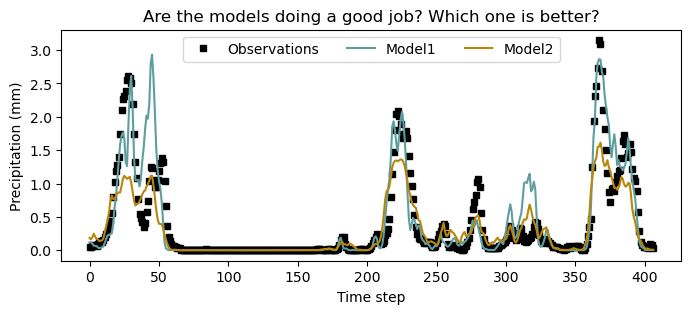

In [5]:
plt.figure(figsize=(8,3))

plt.plot(obs_data,
         marker = 's',
         markersize = 4,
         color = 'k',
         linewidth = 0,
         label = 'Observations')

plt.plot(model_data,
         label = 'Model1',
         color = 'cadetblue')
plt.plot(model2_data, 
         label = 'Model2', 
         color='darkgoldenrod')

plt.ylabel('Precipitation (mm)')
plt.xlabel('Time step')
plt.title('Are the models doing a good job? Which one is better?')
plt.legend(ncol=3)
plt.show()

In [6]:
def bias(obs, model, normalized=False):
    '''
    this function computes the bias between two time series
    '''
    mb = np.mean(model-obs)
    if normalized:
        mb = mb / obs.mean() * 100.0
    return mb


def correlation(obs, model, level=0.95):
    '''
    this function is for the Pearson correlation coefficient, i.e. assuming linear correlation
    another usual non-parametric test is the Spearman correlation (see scipy.stats.spearmanr)
    '''
    nans = np.isnan(obs)+np.isnan(model)
    r = pearsonr(obs[~nans],model[~nans])
    r_coeff = r[0]
    ci = r.confidence_interval(confidence_level=level)
    return r_coeff, ci


def rmse(obs, model, normalize=False):
    '''
    this function computes the root mean squared error of model vs obs
    '''
    rm = np.sqrt(np.nanmean((obs-model)**2))
    if normalize:
        rm = np.sqrt(np.nanmean((obs-model)**2)/np.nansum(obs**2))*100.0
    return rm

In [7]:
b = bias(obs_data, model_data)
bn = bias(obs_data, model_data, normalized=True)
print('The mean bias of model1 compared to the observations is '+str(round(b,2))+' mm, which corresponds to '+str(round(bn,2))+'%')

The mean bias of model1 compared to the observations is 0.02 mm, which corresponds to 5.42%


In [8]:
level = 0.95
r, ci = correlation(obs_data, model_data, level)
print('The Pearson correlation between model1 and the observations is '+str(round(r,2))+' ['+str(round(ci.low,2))+'-'+str(round(ci.high,2))+'] at the '+str(int(level*100.0))+'% level')

The Pearson correlation between model1 and the observations is 0.87 [0.84-0.89] at the 95% level


In [9]:
rms = rmse(obs_data, model_data)
nrms = rmse(obs_data, model_data, normalize = True)
print('The RMSE of model1 is '+str(round(rms,2))+' which corresponds to a normalized value (RRMSE) of '+str(round(nrms,2))+'%')

The RMSE of model1 is 0.35 which corresponds to a normalized value (RRMSE) of 2.25%


In [10]:
b2 = bias(obs_data, model2_data)
r2, ci2 = correlation(obs_data, model2_data, level)
rms2 = rmse(obs_data, model2_data)

In [11]:
results = pd.DataFrame({'model1':[b,r,rms],
                        'model2':[b2,r2,rms2],
                        'stat':['bias','correlation','RMSE']}).set_index('stat')
results

,model1,model2
stat,,
bias,0.021561,-0.083021
correlation,0.867721,0.883723
RMSE,0.345951,0.354064


Model1 has a lower bias but model2 has better correlation.\
RMSE tells us that model1 is more accurate overall.

## 1.2 Multi-model / multi-observation evaluation

Now let's imagine we need to do the same evaluation but we have 6 models and 9 measurement stations, how can we represent the comparison in a synthetic manner?

In [12]:
# Climatology of sea salt aerosol concentration at some polar stations
obs_table = pd.read_csv(path_data+'obs_stations.csv',
                        sep=';',
                        index_col='Month')
obs_table

,Station1,Station2,Station3,Station4,Station5,Station6,Station7,Station8,Station9
Month,,,,,,,,,
1,0.223,0.3831,0.0242,1.0095,0.198,0.0660,1.414,0.140030,0.273849
2,0.304,0.3264,0.0147,1.1805,0.200,0.0309,1.235,0.152581,0.322953
3,0.194,0.2725,0.0134,1.2340,0.450,0.0382,1.110,0.212253,0.319211
4,0.175,0.1942,0.0144,1.1675,0.370,0.0469,0.997,0.186334,0.242500
5,0.091,0.1322,0.0111,1.2271,0.640,0.0255,0.832,0.116160,0.231538
6,0.026,0.0836,0.0007,1.0807,0.360,0.0621,0.785,0.084779,0.187885
7,0.022,0.1700,0.0005,0.7471,0.300,0.0801,0.556,0.074118,0.123759
8,0.023,0.5854,0.0064,0.7851,0.300,0.0768,0.712,0.090127,0.117527
9,0.030,0.4235,0.0067,0.7128,0.300,0.0744,0.892,0.114398,0.168996


In [13]:
# sea salt concentration simulated by 6 different CMIP models at these stations
model1 = xr.Dataset.from_dataframe(pd.read_csv(path_data+'model1.csv', sep=',', index_col='Month'))
model2 = xr.Dataset.from_dataframe(pd.read_csv(path_data+'model2.csv', sep=',', index_col='Month'))
model3 = xr.Dataset.from_dataframe(pd.read_csv(path_data+'model3.csv', sep=',', index_col='Month'))
model4 = xr.Dataset.from_dataframe(pd.read_csv(path_data+'model4.csv', sep=',', index_col='Month'))
model5 = xr.Dataset.from_dataframe(pd.read_csv(path_data+'model5.csv', sep=',', index_col='Month'))
model6 = xr.Dataset.from_dataframe(pd.read_csv(path_data+'model6.csv', sep=',', index_col='Month'))
models = xr.concat([model1,model2,model3,model4,model5,model6], dim='model')
models

<xarray.Dataset> Size: 5kB
Dimensions:   (model: 6, Month: 12)
Coordinates:
  * Month     (Month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: model
Data variables:
    Station1  (model, Month) float64 576B 0.1362 0.1504 ... 0.003558 0.002904
    Station2  (model, Month) float64 576B 0.1331 0.1431 ... 0.004886 0.001722
    Station3  (model, Month) float64 576B 0.321 0.3669 ... 0.00272 0.003637
    Station4  (model, Month) float64 576B 0.7019 1.091 1.536 ... 0.08161 0.04811
    Station5  (model, Month) float64 576B 0.3969 0.6852 1.03 ... 0.08757 0.06657
    Station6  (model, Month) float64 576B 0.1122 0.1641 ... 0.008773 0.003794
    Station7  (model, Month) float64 576B 1.498 1.685 1.29 ... 0.5845 0.6974
    Station8  (model, Month) float64 576B 0.623 0.6581 ... 0.00955 0.01237
    Station9  (model, Month) float64 576B 0.5683 0.6235 ... 0.03895 0.03591

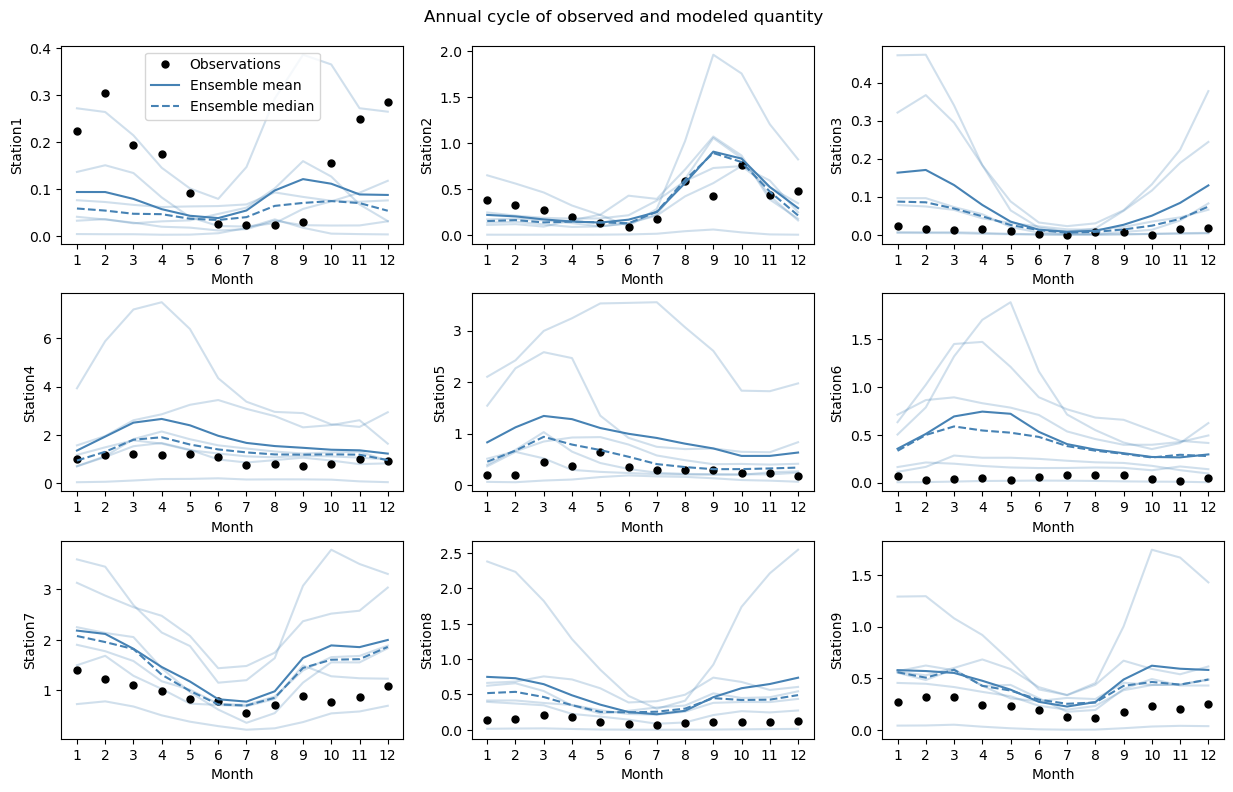

In [14]:
f,axs = plt.subplots(ncols=3,nrows=3,sharey=0,figsize=(15,9))

for i in np.arange(1,10,1):

    # plot each individual model
    for mod in models.model:
        models['Station'+str(i)].sel({'model':mod}).plot(x='Month', 
                                                         color='steelblue',
                                                         alpha=0.25,
                                                         ax=axs.flatten()[i-1])

    obs_table['Station'+str(i)].plot(x='Month',
                                     marker='o',
                                     markersize=5,
                                     linewidth=0,
                                     color='k',
                                     label='Observations',
                                     ax=axs.flatten()[i-1])

    # add ensemble mean and median
    models['Station'+str(i)].mean(dim='model').plot(x='Month',
                                                    label='Ensemble mean',
                                                    color='steelblue',
                                                    ax=axs.flatten()[i-1])
    models['Station'+str(i)].median(dim='model').plot(x='Month',
                                                      label='Ensemble median',
                                                      color='steelblue',
                                                      linestyle='--',
                                                      ax=axs.flatten()[i-1])
    axs.flatten()[i-1].set_xticks(obs_table.index)

axs.flatten()[0].legend()

plt.subplots_adjust(hspace=0.25)
plt.suptitle('Annual cycle of observed and modeled quantity',y=0.92)
plt.show()

OK cool, so what? Are models doing a good job? If so, where? Which one is best where?, etc...

In [15]:
# table to store stats for each model/station
bias_table = pd.DataFrame({'model':['model1','model2','model3','model4','model5','model6','ensemble']}).set_index('model')
corr_table = pd.DataFrame({'model':['model1','model2','model3','model4','model5','model6','ensemble']}).set_index('model')
rmse_table = pd.DataFrame({'model':['model1','model2','model3','model4','model5','model6','ensemble']}).set_index('model')

# add ensemble mean to models
ensemble = models.mean(dim='model')
models_all = xr.concat([models,ensemble], dim='model')

for i in np.arange(1,10,1):
    bias_table['Station'+str(i)] = np.array([bias(obs_table['Station'+str(i)],
                                                  models_all.sel({'model':j})['Station'+str(i)],
                                                  True) for j in models_all.model])
    
    corr_table['Station'+str(i)] = np.array([correlation(obs_table['Station'+str(i)].values,
                                                         models_all.sel({'model':j})['Station'+str(i)].values)[0] for j in models_all.model])
    
    rmse_table['Station'+str(i)] = np.array([rmse(obs_table['Station'+str(i)].values,
                                                  models_all.sel({'model':j})['Station'+str(i)].values, 
                                                  True) for j in models_all.model])
# average accuracy of the individual models
rmse_table['Average'] = rmse_table.mean(axis=1)

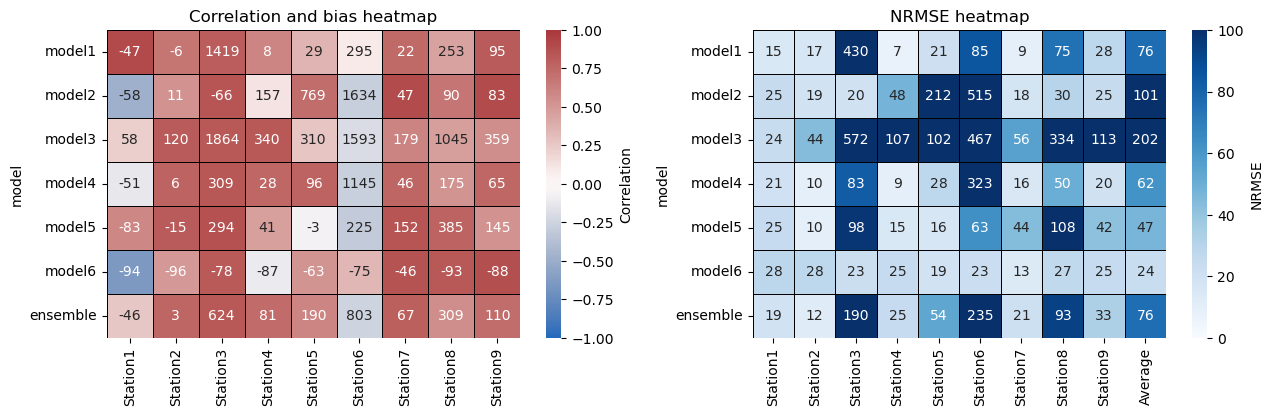

In [16]:
# visual representation of the stats tables
plt.figure(figsize=(15,4))

plt.subplot(121)
sns.heatmap(corr_table,
            annot=bias_table,
            cmap='vlag',
            vmin=-1,
            vmax=1,
            fmt='.0f',
            cbar_kws={'label':'Correlation'},
            linewidths=0.5,
            linecolor='k')
plt.title('Correlation and bias heatmap')

plt.subplot(122)
sns.heatmap(rmse_table,
            annot=True,
            cmap='Blues',
            vmin=0,
            vmax=100,
            fmt='.0f',
            cbar_kws={'label':'NRMSE'},
            linewidths=0.5,
            linecolor='k')

plt.title('NRMSE heatmap')

plt.subplots_adjust(wspace=0.25)
plt.show()

A few conclusions:
- all models do a good job at representing the variability at Stations 2,3,7,8,9 and station 2 has the lower overall bias, which makes it the more accurately simulated station (lower ensemble NRMSE)
- model 6 has good correlations and decent biases overall, which makes it the more accurate model (lower average NRMSE)

### Synthetic representation of model spread

- Interquartile range (IQR)

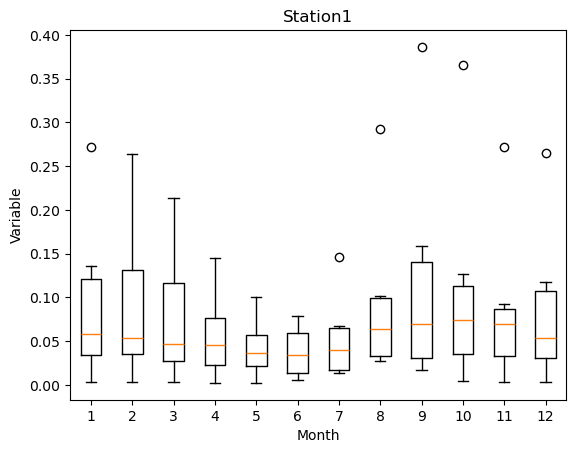

IQR is the "length" of the boxes, i.e. P75-P25


In [20]:
# simple boxplot to illustrate model spread at Station1
plt.boxplot(models.Station1)
plt.title('Station1')
plt.ylabel('Variable')
plt.xlabel('Month')
plt.show()

print('IQR is the "length" of the boxes, i.e. P75-P25')

In [21]:
p75 = models.quantile(0.75, dim='model')
p25 = models.quantile(0.25, dim='model')
p50 = models.quantile(0.50, dim='model')

In [22]:
iqr = (p75 - p25).to_dataframe()
iqrn = ((p75 - p25) / p50).drop_vars('quantile').to_dataframe()

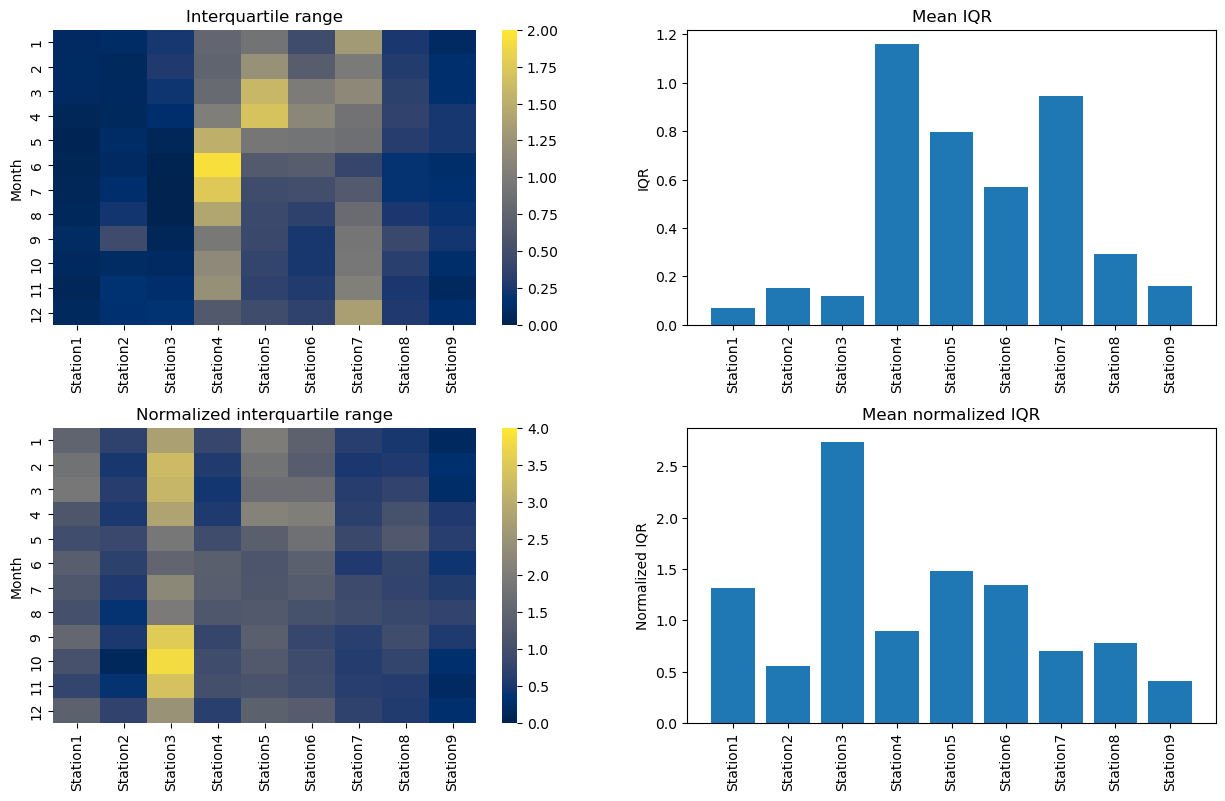

In [23]:
plt.figure(figsize=(15,9))

plt.subplot(221)
sns.heatmap(iqr, vmin=0, vmax=2, cmap='cividis')
plt.title('Interquartile range')

plt.subplot(223)
sns.heatmap(iqrn, vmin=0, vmax=4, cmap='cividis')
plt.title('Normalized interquartile range')


plt.subplot(222)
plt.bar(range(9),iqr.mean(axis=0))
plt.xticks(range(9),iqr.columns, rotation=90)
plt.ylabel('IQR')
plt.title('Mean IQR')

plt.subplot(224)
plt.bar(range(9),iqrn.mean(axis=0))
plt.xticks(range(9),iqrn.columns, rotation=90)
plt.ylabel('Normalized IQR')
plt.title('Mean normalized IQR')

plt.subplots_adjust(hspace=0.35)
plt.show()

# 2. Analysing time series

## 2.1 Finding the main frequencies of the signal: Fourier transform

We are in Grenoble after, so we need to talk about Joseph Fourier who founded the University of Grenoble.

A time-dependent signal $S(t)$ with periodicity $P$ can be approximated by a combination of sine waves of different frequencies. This combination is a Fourier series:

$$S(t) = \sum_{k=-\infty}^{\infty} c_k e^{-2 \pi \frac{k}{P} t}$$

The Fourier transform (in this case fast Fourier transform - fft) computes the $c_k$ coefficients, which tell us the importance of the $k$-th frequency in this signal

### Simple example with a sine function

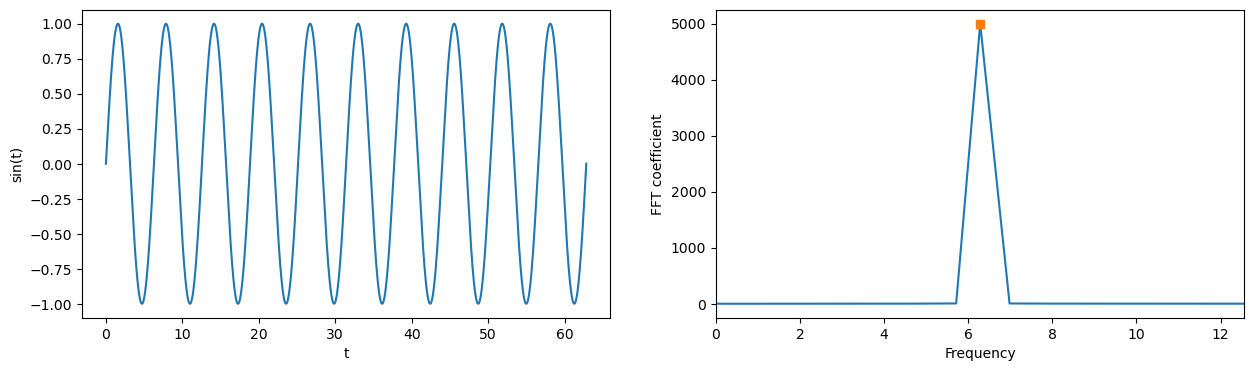

fundamental frequency: 6.283185307179586
2π=6.283185307179586
close enough...


In [24]:
n = 10000
tmax = 10*2*math.pi
t = np.linspace(0,tmax,n)
sin_test = np.sin(t)

# Fourier transform
Z = np.fft.fft(sin_test, axis=0)[1:int(n/2)]
# Fourier transform frequencies
f = np.fft.fftfreq(len(sin_test), d=tmax/n)[1:int(n/2)]

plt.figure(figsize=(15,4))

plt.subplot(121)

plt.plot(t,sin_test)
plt.xlabel('t')
plt.ylabel('sin(t)')

plt.subplot(122)

plt.plot(1/f,np.abs(Z))

plt.plot(2*math.pi,np.max(np.abs(Z)),marker='s')

plt.xlim(0,4*math.pi)
plt.xlabel('Frequency')
plt.ylabel('FFT coefficient')

plt.show()

print('fundamental frequency: '+str(1/f[np.argmax(np.abs(Z))]))
print('2'+u'\u03c0'+'='+str(2*math.pi))
print('close enough...')

### Now with real (yet still simple) data

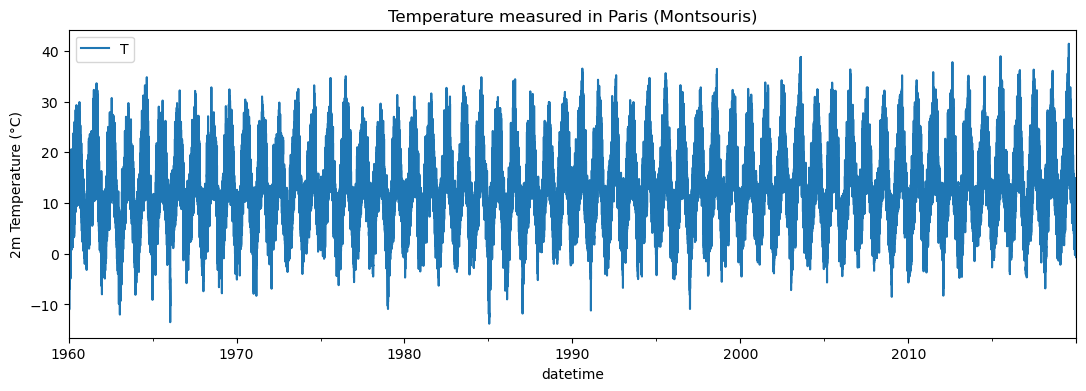

In [25]:
# temperature measured in Paris every 3 hours
t_paris = pd.read_csv(path_data+'T_Paris_3h.csv', parse_dates=['datetime'])

# keep only complete years to simplify
t_paris = t_paris[(t_paris.datetime.dt.year>=1960) & (t_paris.datetime.dt.year<=2019)]

t_paris.plot(x='datetime',
             y='T',
             figsize=(13,4),
             ylabel='2m Temperature (°C)',
             title='Temperature measured in Paris (Montsouris)')
plt.show()

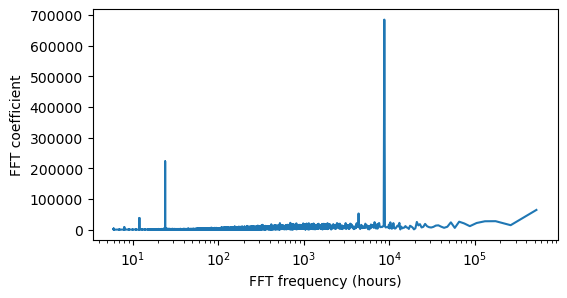

In [26]:
# interpolate missing values
signal = t_paris['T'].interpolate(method='linear').values 
n = signal.size

# Fourier transform coefficients
Z = np.fft.fft(signal, axis=0)[1:int(n/2)]

# Fourier transform frequencies
f = np.fft.fftfreq(signal.shape[-1])[1:int(n/2)]

# f gives us the frequencies in the sampling rate of the variable 
# so here it is 1 per time step, i.e. 1 per 3 hours
# we would like to get the period in hours T = 1/f*3
# we round it to make it more readable
f_to_hours = np.round(1/f*3)

plt.figure(figsize=(6,3))
plt.plot(f_to_hours, np.abs(Z))
plt.xscale('log')
plt.ylabel('FFT coefficient')
plt.xlabel('FFT frequency (hours)')

plt.show()

In [27]:
ZZ = Z.copy()

# not very clever way to extract the 10 most important frequencies in the signal
# but it works...
N = 10
outz = []

for i in range(N):
    # argument of the largest coefficient
    ag = np.nanargmax(np.abs(ZZ))
    # corresponding period
    freq_ag = f_to_hours[np.nanargmax(np.abs(ZZ))]
    
    outz = np.append(outz, freq_ag)

    # set NaN values for coefficients corresponding to the same frequency to avoid repletion
    f_eq = np.where(f_to_hours==f_to_hours[np.nanargmax(np.abs(ZZ))])
    ZZ[f_eq] = np.nan

In [28]:
hours = []
days = []
years = []
for o in outz:
    if o<24:
        hours = np.append(hours, o)
    elif (o>=24) and (o<365*24):
        days = np.append(days, o/24)
    else:
        years = np.append(years, o/24/365.25)

hours = np.sort(hours)
days = np.sort(np.round(days,2))
years = np.sort(np.round(years,2))

In [29]:
print('Hourly frequencies:')
print(hours)
print('Daily frequencies:')
print(days)
print('Yearly frequencies:')
print(years)

Hourly frequencies:
[12.]
Daily frequencies:
[  1.   182.62 280.96]
Yearly frequencies:
[ 1.   2.4  7.5 15.  20.  60. ]


## 2.2 Curve fitting

### 2.2.1 Linear regression

In [30]:
# surface ozone and surface temperature in Grenoble from CAMS - how are they related?
o3_temp = xr.open_dataset(path_data+'temp_ozone_surface_Grenoble_CAMS.nc').squeeze()

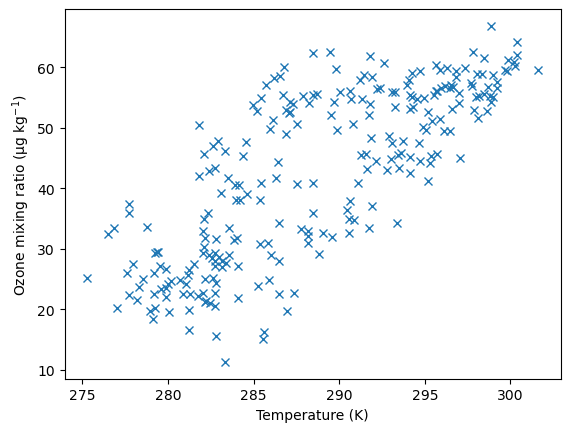

In [31]:
x = o3_temp.t.values
y = o3_temp.go3.values*1e9

plt.plot(x, y, marker='x', linewidth=0)
plt.xlabel('Temperature (K)')
plt.ylabel('Ozone mixing ratio ('+u'\u03bc'+'g kg$^{-1}$)')
plt.show()

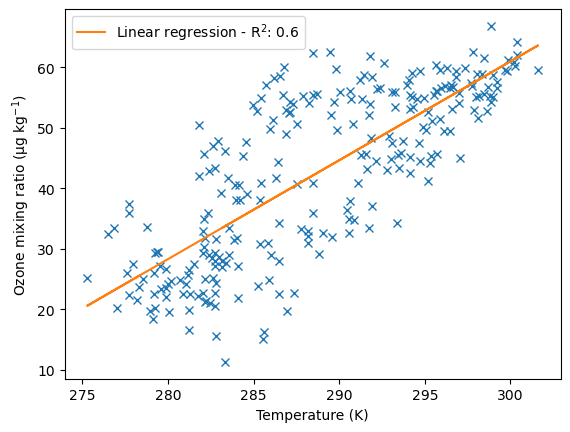

Temperature explains 59% of the variance in ozone


In [32]:
def regression(x, y, order=1):
    reg = np.polyfit(x, y, order)
    p_x = 0
    for i in range(order+1):
        p_x = p_x + reg[order-i]*x**i
    r2 = r2_score(y, p_x)
    return reg, p_x, r2

reg1, p_x1, r21 = regression(x,y)

plt.plot(x, y, marker='x', linewidth=0)

plt.plot(x,p_x1, label='Linear regression - R$^2$: '+str(round(r21,3)))

plt.xlabel('Temperature (K)')
plt.ylabel('Ozone mixing ratio ('+u'\u03bc'+'g kg$^{-1}$)')

plt.legend()
plt.show()

print('Temperature explains '+str(int(r21*100))+'% of the variance in ozone')

### 2.2.2 General curve fitting

Let's take this opportunity to learn how to get CMIP data in a notebook without download.

In [33]:
import intake
import cftime

In [34]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [35]:
cat = col.search(variable_id=['tos'], 
                 member_id=['r1i1p1f1'],
                 source_id=['NorESM2-LM'],
                 experiment_id=['historical','ssp585'],
                 table_id=['Omon'])

In [36]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [37]:
dataset_list = list(dset_dict.keys())
dataset_list

['ScenarioMIP.NCC.NorESM2-LM.ssp585.Omon.gn',
 'CMIP.NCC.NorESM2-LM.historical.Omon.gn']

In [38]:
ssp = dset_dict[dataset_list[0]]
ssp = ssp.mean(dim=['i','j']).squeeze()
ssp = ssp.assign_coords({'time':ssp.time.convert_calendar('standard', use_cftime=False).time})
ssp = ssp.resample({'time':'YE'}).mean().compute()

In [39]:
hist = dset_dict[dataset_list[1]]
hist = hist.mean(dim=['i','j']).squeeze()
hist = hist.assign_coords({'time':hist.time.convert_calendar('standard', use_cftime=False).time})
hist = hist.resample({'time':'YE'}).mean().compute()

In [40]:
ocean_temp = xr.merge([hist,ssp])

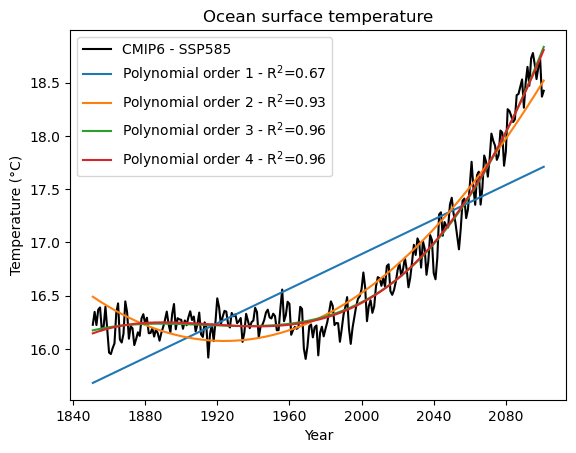

In [41]:
plt.plot(ocean_temp.time,
         ocean_temp.tos,
         color='k', 
         label='CMIP6 - SSP585')


for order in np.arange(1,5):
    fit_ocean_temp = regression(np.arange(0,len(ocean_temp.time)),ocean_temp.tos,order)
    r = r2_score(ocean_temp.tos,fit_ocean_temp[1])
    plt.plot(ocean_temp.time,
             fit_ocean_temp[1],
             label='Polynomial order '+str(order)+' - R$^2$='+str(round(r,2)))

plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Ocean surface temperature')
plt.show()

## 2.3 Testing the difference between two data sets: Wilcoxon test

Imagine you are trying to estimate the effect of some change in the atmosphere on some variable, using sensitivity analysis. How do you quantify it?

We are using CMIP6 data in this example too, but I pre-downloaded it. Because we have plenty of storage space thanks to Myke so we might as well use it.

In [48]:
# CMIP6 pre-industrial climate - no anthropogenic aerosols
control = xr.open_dataset(path_data+'clt_Amon_IPSL-CM6A-LR-INCA_piClim-control_r1i1p1f1_gr_185001-187912.nc')

# CMIP6 pre-industrial climate - 2014 anthropogenic aerosols
perturb = xr.open_dataset(path_data+'clt_Amon_IPSL-CM6A-LR-INCA_piClim-aer_r1i1p1f1_gr_185001-187912.nc')

In [51]:
# change in total cloud fraction due to anthropogenic aerosols
diff = perturb-control

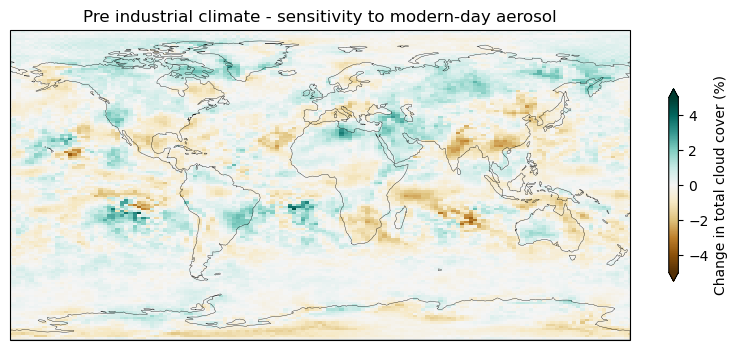

In [50]:
plt.figure(figsize=(10,5))

ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent([-180,180,-90,90], ccrs.PlateCarree())

ax.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=10,facecolor=(1,1,1,0),linewidth=0.25)


c=ax.pcolormesh(diff.lon,
                diff.lat,
                diff.clt.mean(dim='time'),
                cmap='BrBG',
                transform=ccrs.PlateCarree(),
                vmin=-5,
                vmax=5)

plt.colorbar(c, label='Change in total cloud cover (%)', shrink=0.5, extend='both')
plt.title('Pre industrial climate - sensitivity to modern-day aerosol')

plt.show()

### There seems to be changes everywhere on average, but where is it actually significant?

i.e. is the distribution symetrical around 0 or not?

We will use the wilcoxon test for that, which is a non-parametric version of the Student's test. There are other options out there though.

In [52]:
wilco_test = wilcoxon(diff.clt).pvalue

We want a mask where we can reject the null hypothesis that the data has not changed at the 95% level i.e. where pvalue is < 0.05.

> Always remember to give as little (p)value as possible to your significant other

In [53]:
wilco_mask = wilco_test.copy()
wilco_mask = xr.where(wilco_mask<0.05, 1, np.nan)

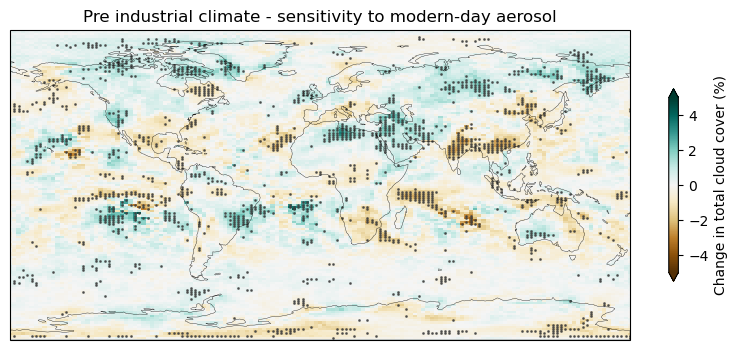

In [54]:
plt.figure(figsize=(10,5))

ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent([-180,180,-90,90], ccrs.PlateCarree())

ax.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=10,facecolor=(1,1,1,0),linewidth=0.25)


c=ax.pcolormesh(diff.lon,
                diff.lat,
                diff.clt.mean(dim='time'),
                cmap='BrBG',
                transform=ccrs.PlateCarree(),
                vmin=-5,
                vmax=5)

plt.colorbar(c, label='Change in total cloud cover (%)', shrink=0.5, extend='both')
plt.title('Pre industrial climate - sensitivity to modern-day aerosol')

x,y = np.meshgrid(diff.lon,diff.lat)
x[np.isnan(wilco_mask)] = np.nan

ax.plot(x,
        y,
        linewidth=0,
        marker='o',
        markersize=1,
        markerfacecolor=(0.25,0.25,0.25,0.75),
        markeredgecolor=(0.25,0.25,0.25,0.75),
        transform=ccrs.PlateCarree())

plt.show()

# 3. Evaluating trends
- How much is the trend?
- How significant is it?
- How do I deal with seasonality?

In [55]:
# annual temperature from MERRA2
temp_glob_yr = xr.open_dataset(path_data+'MERRA2_t2m_yearly_NH.nc').load().squeeze()['T2M']
# monthly temperature form MERRA2
temp_glob_mn = xr.open_dataset(path_data+'MERRA2_t2m_monthly_NH.nc').load().squeeze()['T2M']

In [56]:
def linear_slope(y):
    '''
    function that returns the slope of the trend computed with MannKendall test
    '''
    pmk = mk.original_test(y, alpha=0.05)
    slope = pmk.slope
    return slope

def compute_trend(ds, dim="time"):
    '''
    Calculate the trend of all variables in a dataset using pymannkendall for all grid points.
    '''
    trend = xr.apply_ufunc(linear_slope,
                           ds,
                           input_core_dims=[[dim]],
                           output_core_dims=[[]],
                           output_dtypes=[float],
                           vectorize=True,
                           dask="parallelized")

    return trend

def linear_slope_sig(y):
    '''
    function that returns the slope and significance of the trend computed with MannKendall test
    '''
    pmk = mk.original_test(y, alpha=0.05)
    slope = pmk.slope
    sig = pmk.h
    if not sig:
        slope=np.nan
    return slope
    

def compute_trend_sig(ds, dim="time"):
    '''
    Calculate the trend of all variables in a dataset using pymannkendall for all grid points.
    '''
    trend = xr.apply_ufunc(linear_slope_sig,
                           ds,
                           input_core_dims=[[dim]],
                           output_core_dims=[[]],
                           output_dtypes=[float],
                           vectorize=True,
                           dask="parallelized")
    
    return trend

In [57]:
trend_tyr = compute_trend(temp_glob_yr, dim='time')

In [58]:
%%time
trend_tyr_sig = compute_trend_sig(temp_glob_yr, dim='time')

CPU times: user 42.5 s, sys: 0 ns, total: 42.5 s
Wall time: 42.5 s


In [49]:
%%time
trend_tmn_sig = compute_trend_sig(temp_glob_mn, dim='time')

CPU times: user 6min 2s, sys: 667 ms, total: 6min 3s
Wall time: 6min 3s


Longer time series mean longer computations... you might want to resample your data first when possible

In [50]:
def plott(trend, vmax=1, title=''):
    '''
    plot trends
    '''
    plt.figure(figsize=(10,7))

    ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.set_extent([-180,180,0,90], ccrs.PlateCarree())

    ax.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=10,facecolor=(1,1,1,0),linewidth=0.25)


    c=ax.pcolormesh(trend.lon,
                    trend.lat,
                    trend,
                    cmap='seismic',
                    transform=ccrs.PlateCarree(),
                    vmin=-vmax,
                    vmax=vmax)

    c.cmap.set_bad('k')
    plt.colorbar(c, label='°C yr$^{-1}$', shrink=0.3)
    plt.title(title)

    plt.show()

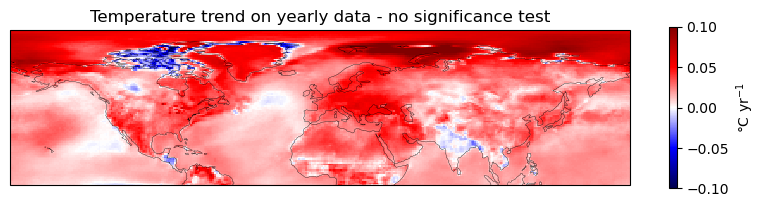

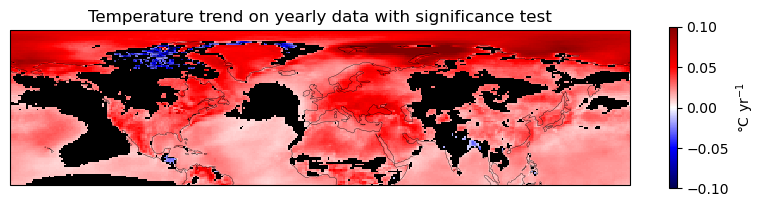

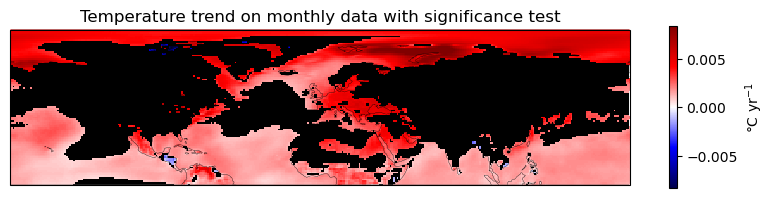

In [51]:
plott(trend_tyr, vmax=0.1, title='Temperature trend on yearly data - no significance test')
plott(trend_tyr_sig, vmax=0.1, title='Temperature trend on yearly data with significance test')
plott(trend_tmn_sig*12, vmax=0.1, title='Temperature trend on monthly data with significance test')

In [52]:
def linear_slope_season(y):
    '''
    function that returns the slope of the trend computed with seasonal MannKendall test
    '''
    pmk = mk.seasonal_test(y, alpha=0.05)
    slope = pmk.slope
    sig = pmk.h
    if not sig:
        slope=np.nan
    return slope


def compute_trend_season(ds, dim="time"):
    '''
    Calculate the trend of all variables in a dataset using seasonal pymannkendall for all grid points.
    '''
    trend = xr.apply_ufunc(linear_slope_season,
                           ds,
                           input_core_dims=[[dim]],
                           output_core_dims=[[]],
                           output_dtypes=[float],
                           vectorize=True,
                           dask="parallelized")

    return trend

In [55]:
%%time
trend_tmn_seas = compute_trend_season(temp_glob_mn, dim='time')

CPU times: user 4min 50s, sys: 108 ms, total: 4min 50s
Wall time: 4min 50s


Using the adequate test is faster

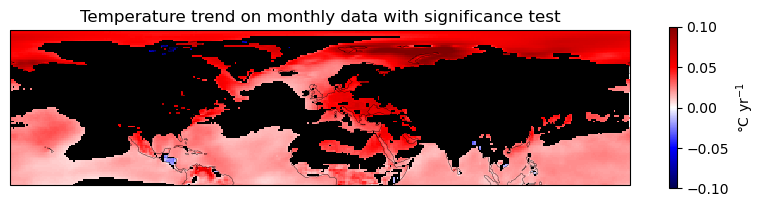

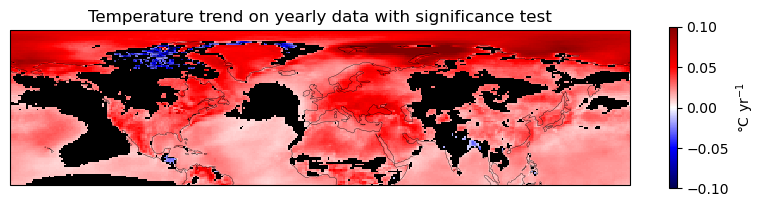

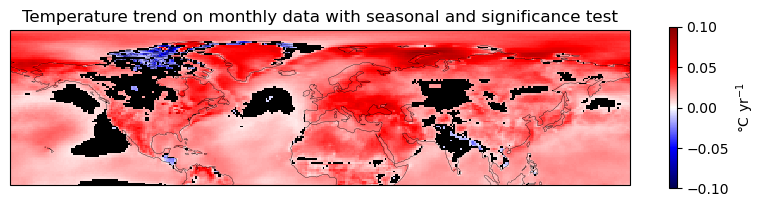

In [56]:
plott(trend_tmn_sig*12, vmax=0.1, title='Temperature trend on monthly data with significance test')
plott(trend_tyr_sig, vmax=0.1, title='Temperature trend on yearly data with significance test')
plott(trend_tmn_seas, vmax=0.1, title='Temperature trend on monthly data with seasonal and significance test')

# Bonus section - time gained from using apply_ufunc

In [57]:
def greedy_trend(ds):
    '''
    naive way of computing trends point-wise
    '''
    trend = np.zeros((len(ds.lat),len(ds.lon)))
    for la in range(len(ds.lat)):
        for lo in range(len(ds.lon)):
            trend[la,lo] = mk.original_test(ds.isel({'lat':la,'lon':lo}), alpha=0.05).slope
    return trend

In [58]:
%%time
test1 = greedy_trend(temp_glob_yr)

CPU times: user 47.1 s, sys: 25 ms, total: 47.1 s
Wall time: 47.1 s


In [59]:
%%time
test2 = compute_trend(temp_glob_yr, dim='time')

CPU times: user 39.5 s, sys: 21 ms, total: 39.6 s
Wall time: 39.6 s


### The difference seems underwhelming with an easy example like this, but this is still a 16% gain in computation time

## (not well) hidden bonus section 
that has nothing to do with the lecture but if you've reached this far you are probably bored so why not do something fun [https://github.com/rlapere/pymusic](https://github.com/rlapere/pymusic)